# Rashmit    16200161     Assignment2



In [1]:
# Imported libraries in use

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
from nltk.tokenize.regexp import WordPunctTokenizer
from collections import Counter
import nltk.corpus
from nltk.corpus import stopwords
%matplotlib inline

## TASK 1
* 1.a Load the text corpus generated in Part 1.
* 1.b Apply any appropriate pre-processing steps 
    * stop words removal
    * tokenisation
    * lemmatization
* 1.c construct a document-term matrix representation of the corpus.
    * computing frequency tf-idf

In [2]:
# remove non ascii values from string
def removeNonAsciiKeywords(s): return "".join(i for i in s if ord(i)<128)

In [3]:
# 1.a Load the text corpus generated in Part 1 - The unstructured Data
# path to the scraped newsData file generated from the first step.
newsFile = "news/newsData.txt"
newsTitlesFile = "news/titles.txt"

# storing the contents of the file. 
newsData = open(newsFile,"r")
newsTitles = open(newsTitlesFile,"r")

# From previous step, each article in this file is stored in one line.
# Hence, capturing each individual news article and titles separately.
listOfNewsArticles = newsData.readlines()
newsID = list(range(len(listOfNewsArticles)))
listOfTitles = newsTitles.readlines()
newsData.close()
newsTitles.close()

cleanTitles = []
# Remove ascii keywords from titles
for title in listOfTitles:
    cleanTitles.append(removeNonAsciiKeywords(title))

# Assigning cleanTitles to listOfTitles
listOfTitles = cleanTitles

# This is unstructured text
print("News Articles loading successful. Total number of articles are", len(listOfNewsArticles))
print("News Titles loading successful. Total number of Titles are", len(listOfTitles))

News Articles loading successful. Total number of articles are 1131
News Titles loading successful. Total number of Titles are 1131


## Applying pre-processing steps and constructing the document-term matrix 


In [4]:
# defined function to preprocess
def lemma_tokenizer(text):
    
    # using scikit-learn tokenizer to create tokens
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    
    # using NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

In [5]:
# Remove stop words as per the english dictionary
# Have words occured more than 5 times 
# Lemmatize using WordNet Lemmatizer. 
# Convert into tf-idf matrix 

vectorizer = TfidfVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer)
# deploy vectorizer object for our list of news article.
X = vectorizer.fit_transform(listOfNewsArticles)

# display number of rows and columns
print("Size of document term matrix",X.shape)
print("Type of document term matrix",type(X))

# fetching features from vectorizer
terms = vectorizer.get_feature_names()
# fetching vocabulary from vectorizer
vocab = vectorizer.vocabulary_

print("News articles vocabulary has %d distinct terms" %len(terms))
vocabDF = pd.DataFrame({"vocab":terms}, index=terms)


Size of document term matrix (1131, 5611)
Type of document term matrix <class 'scipy.sparse.csr.csr_matrix'>
News articles vocabulary has 5611 distinct terms


# TASK 2
### * Summarise the overall corpus by identifying the most characteristic terms and phrases in the corpus.

In [6]:
# Funtion to get top n tfidf values 
def top_tfidf_feats(row, features, top_n):
    rank = list(range(1,top_n+1))
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.insert(0, "rank", rank)
    df.columns = ['rank', 'term', 'tfidf score']
    return df

In [7]:
# Return the top n features that on average are most 
# important amongst documents in rows indentified by indices in grp_ids.
def top_mean_feats(X, features, top_n, grp_ids=None, min_tfidf=0.1):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

### Most characterstic terms

In [8]:
print("Most characterstics terms in the Corpus.")
# Display top 15 most characterstics terms 
# based on tf-idf
display(HTML(top_mean_feats(X, terms, 15).to_html(index = False)))



Most characterstics terms in the Corpus.


rank,term,tfidf score
1,cent,0.022373
2,hospital,0.020430
3,tax,0.017878
4,game,0.016657
5,health,0.015861
6,ireland,0.013032
7,mobile,0.012327
8,hse,0.012208
9,bank,0.012038
10,chelsea,0.010579


## Most characterstics phrases (bigrams)

In [9]:
# vectorizing for bigrams only by giving ngram minimum and maximum range = 2.
vectorizerBigram = TfidfVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer, ngram_range=(2,2))
# deploy vectorizer object for our list of news article.
XBigram = vectorizerBigram.fit_transform(listOfNewsArticles)
termsBigram = vectorizerBigram.get_feature_names()
print("Most frequent bigrams.")
# Display top 15 most characterstics phrases with their tfidf scores, in the Corpus.
display(HTML(top_mean_feats(XBigram, termsBigram, 15).to_html(index = False)))

Most frequent bigrams.


rank,term,tfidf score
1,champion league,0.011991
2,manchester united,0.011779
3,year old,0.011656
4,said mr,0.011208
5,online news,0.011084
6,euro zone,0.008871
7,mobile phone,0.008813
8,medical card,0.008349
9,chief executive,0.008329
10,world cup,0.007969


# TASK 3

## Applying two clustering algorithms:
### K-Means Algorithmn

In [10]:
# Applying each algorithm several times with different parameter values to get the most accurate number of K.
# Found 4 to be most appropiate for our dataset.
numberOfClusters = 4
# k-means object
kMeansModel = KMeans(n_clusters = numberOfClusters)
# Fitting Kmeans object to document-term matrix
kMeansModel.fit(X)
# fetching list of labels for each article and storing it in clusters.
clusters = kMeansModel.labels_.tolist()
# print cluster number corresponding to each article
print(clusters)

[3, 0, 1, 3, 3, 0, 1, 2, 2, 2, 3, 1, 0, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 3, 2, 2, 2, 3, 3, 0, 0, 0, 3, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 3, 2, 2, 2, 3, 2, 2, 3, 3, 1, 1, 3, 2, 1, 1, 1, 1, 3, 0, 1, 1, 1, 2, 1, 3, 0, 2, 0, 3, 3, 3, 1, 0, 1, 2, 3, 3, 1, 0, 0, 1, 1, 3, 0, 2, 3, 0, 2, 2, 2, 0, 3, 3, 0, 3, 3, 0, 1, 1, 2, 3, 3, 3, 3, 3, 2, 3, 3, 0, 0, 0, 0, 0, 3, 2, 1, 0, 3, 1, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 3, 2, 2, 1, 3, 3, 0, 0, 0, 3, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 3, 3, 1, 3, 3, 0, 0, 2, 2, 0, 3, 1, 2, 2, 3, 0, 2, 1, 2, 0, 0, 0, 3, 2, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 2, 0, 2, 0, 1, 3, 1, 0, 2, 1, 0, 2, 3, 0, 2, 2, 0, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 2, 0, 2, 3, 2, 3, 3, 2, 2, 3, 3, 1, 1, 1, 2, 0, 3, 0, 1, 3, 3, 3, 0, 1, 1, 3, 3, 1, 0, 2, 0, 0, 0, 3, 0, 0, 3, 0, 3, 2, 1, 0, 0, 2, 0, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 3, 0, 0, 0, 1, 0, 0, 3, 2, 0, 1, 3, 2, 3, 1, 2, 2, 1, 0, 0, 3, 1, 2, 3, 2, 1, 1, 3, 3, 1, 2, 0, 2, 3, 3, 1, 1, 3, 1, 0, 1, 2, 2, 0, 0, 1, 1, 2, 

In [11]:
# creating a articleDict which has all necessary information for further steps.
articleDict = {'newsID': newsID, 'titles': listOfTitles, 'newsText': listOfNewsArticles, 'cluster': clusters}

# creating dataframe based on the articleDict
kmeansDF = pd.DataFrame(articleDict, index = [clusters], columns = ["cluster", "newsID", "titles"])

# article distribution in clusters.
kmeansDF['cluster'].value_counts()

2    316
0    306
3    265
1    244
Name: cluster, dtype: int64

In [12]:
print("\nTop words in each cluster:\n")
# fetch cluster centers based on the closeness of centroid.
centroids = kMeansModel.cluster_centers_.argsort()[:, ::-1]

# Fetch closest terms to the centroid
for i in range(numberOfClusters):
    print("For cluster %d words are:" % i, end='\n')
    # Display top-5 closest words
    for index in centroids[i, :6]:
        print(' %s' % (vocabDF.ix[terms[index].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')).decode('utf-8'))
    print()


Top words in each cluster:

For cluster 0 words are:
 mobile
 phone
 people
 said
 technology
 game

For cluster 1 words are:
 hospital
 health
 hse
 patient
 said
 child

For cluster 2 words are:
 cent
 tax
 bank
 ireland
 said
 economy

For cluster 3 words are:
 club
 chelsea
 game
 player
 wa
 goal



In [13]:
# Fetching articles in each cluster
for i in range(numberOfClusters):
    print("Following articles are in Cluster %d:" % i, end="")
    for newsID in kmeansDF.ix[i]["newsID"].values.tolist():
        print(' %s,' % newsID, end='')
    print("\n") #add whitespace

Following articles are in Cluster 0: 1, 5, 12, 13, 21, 29, 30, 31, 33, 37, 40, 61, 68, 70, 75, 81, 82, 86, 89, 93, 96, 99, 111, 112, 113, 114, 115, 119, 135, 138, 139, 149, 150, 151, 153, 164, 172, 173, 176, 182, 186, 187, 188, 192, 193, 195, 199, 202, 204, 208, 211, 214, 217, 220, 229, 243, 245, 250, 256, 258, 259, 260, 262, 263, 265, 269, 270, 272, 275, 276, 278, 281, 282, 283, 286, 287, 288, 290, 291, 294, 303, 304, 316, 324, 328, 329, 335, 336, 338, 343, 352, 364, 365, 367, 380, 381, 387, 390, 392, 393, 395, 397, 400, 406, 407, 409, 415, 429, 430, 433, 436, 447, 449, 462, 468, 471, 472, 474, 479, 481, 483, 487, 492, 493, 497, 505, 508, 510, 511, 512, 520, 522, 530, 533, 534, 536, 539, 542, 543, 546, 550, 551, 553, 554, 555, 567, 570, 573, 576, 583, 587, 589, 590, 599, 600, 602, 603, 606, 607, 615, 616, 619, 622, 623, 625, 629, 630, 633, 638, 640, 642, 652, 655, 658, 659, 661, 662, 666, 667, 670, 675, 676, 682, 692, 693, 702, 709, 711, 716, 717, 722, 727, 729, 730, 739, 745, 747, 75

## Agglomerative Clustering 

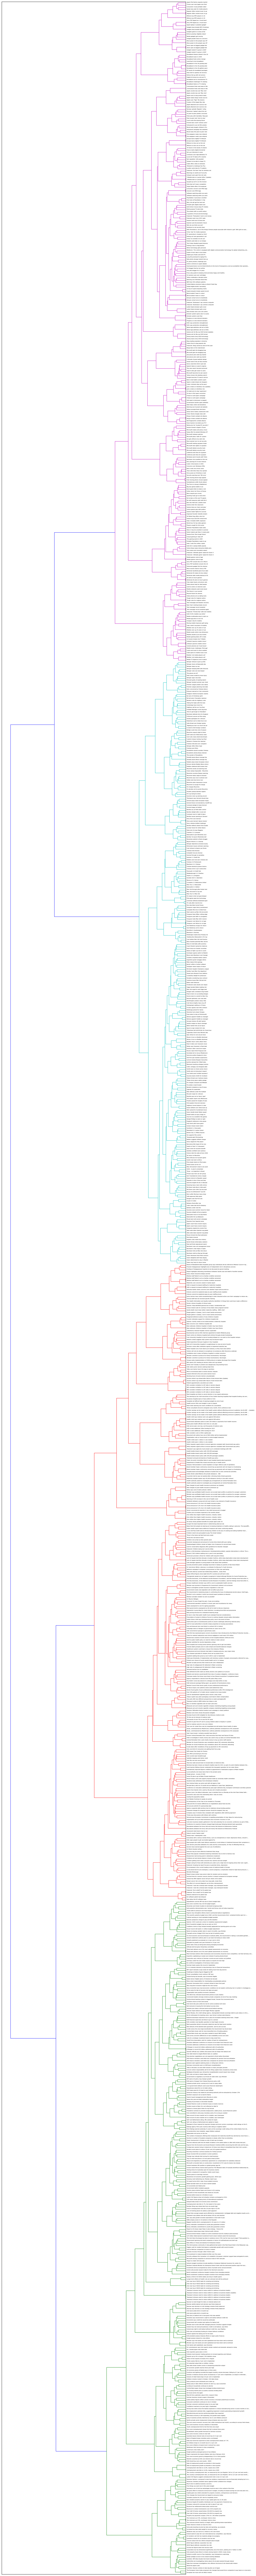

In [14]:
# Cosine similarity for X
distance = 1 - cosine_similarity(X)
# Using ward clustering generating linkageMatrix
linkageMatrix = ward(distance) 
# Setting plot size
fig, ax = plt.subplots(figsize=(15, 150))

# Setting dendrogram configurations
ax = dendrogram(linkageMatrix, orientation="left", labels=listOfTitles)

plt.tick_params(\
    axis= 'x',          
    which='both',       
    bottom='off',       
    top='off',          
    labelbottom='off')

# setting tight layout for the plot
plt.tight_layout() 

In [15]:
# close plot
plt.close()

# TASK 4
###  Summarise the contents of the clusters. 
###  Based on your summary, suggest a topic/theme for each cluster.

##### To compute the summary of multiple documents based on the clusters. We are considering all the article Ids 
##### of the news and taking out the title of those specific news from the titles page.
##### Considering that the title of the news best summarize the news, we then compute 4 different documents
##### with the list of titles belonging to the same cluster from Task 3 
##### Further applying the preprocessing steps to the titles and taking the top 10 news based on the score computed on the basis of frequency of ##### tokens.

In [16]:
# Function to preprocess titles document
def preprocessTitles(titles):
    # nltk tokenizer for tokenizing titles
    tokenizer = WordPunctTokenizer()
    # tokenise_titles will be the list of tokenise titles
    tokenise_titles = []
    for title in titles:
        # Tokenize each title
        tokens = tokenizer.tokenize(title.lower())
        # Add the tokens to tokenise_titles
        tokenise_titles.append(tokens)
        
    # remove stop words from titles tokens using nltk stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    # Count tokens in each title
    token_counts = Counter()
    # Count tokens
    for token in token_counts:
        # Set non-alphanumeric tokens count to 0
        if not token[0].isalpha():
            token_counts[token] = 0
        # Set stopword tokens count to 0
        elif token in stopwords:
            token_counts[token] = 0
    
    # assign scores to the sentence based on the number of popular tokens calculated above.
    scores = []
    for sentence in tokenise_titles:
        score = 0
        for token in sentence:
            score += token_counts[token]
        scores.append(score)

    # Combining scores and their corresponding titles
    score_dict = {'score': scores, 'title': titles}
    # Creating dataframe of score_dict and sort it based on its index with highest score
    score_df = pd.DataFrame(score_dict, index = [scores], columns = ["score", "title"])
    score_df.sort_index(inplace=True, ascending= False)
    
    # Convert score_df's title column into list. This column is already sorted in above step.
    sorted_titles = score_df.ix[:, 1].tolist()
    
    # Check duplicate titles, if there are, remove them.
    top_titles = list(set(sorted_titles))
    
    # Print top 10 titles as summary of cluster
    top_ten = []
    for item in top_titles[:10]:
        top_ten.append(item)
    top_ten_list = "".join(top_ten)
    print(top_ten_list)

In [17]:
# Print top 10 sentences based on number of occurences of token for each cluster
for i in range(numberOfClusters):
    print("Summary of cluster #", i, "\n")
    titles = []
    for title in kmeansDF.ix[i]['titles'].values.tolist():
        titles.append(title)
    preprocessTitles(titles)
    print("\n")

Summary of cluster # 0 

Peer-to-peer nets 'here to stay'
Digital UK driven by net and TV
Tough rules for ringtone sellers
Broadband challenges TV viewing
The future in your pocket
Ban hits Half-Life 2 pirates hard
Sony wares win innovation award
Featured: 'Brainwave' cap controls computer
Sony PSP console hits US in March
Yahoo moves into desktop search



Summary of cluster # 1 

Most who died by suicide had relationship problems , study finds
Department of Health files reveal executive pay in health sector
Everybody with a serious mental illness, such as schizophrenia or manic depressive illness, should h...
Rotunda master raises concerns over whether report will be acted on
Economic background and amount of screen-time linked with poor eating
Funds down after revelations of top-up payments to CRC executives
Doctors have warned against the over-use of antibiotics. 
HSE concerned at upsurge in gonorrhoea cases
Aviva announces 5.2% rise in its health insurance plans
Featured: Children

##### Based on the summary of the cluster1, the theme or topics of clusters are following:
##### Cluster0 - Technology and Internet News
##### Cluster1 - Medical and Health News
##### Cluster2 - Business and Economy News
##### Cluster3 - Sports News
